# Домашнее задание 2. Нейронные сети

### Хрулева Елена ИУ8-83
### Вариант 19

## Наборы данных

### Задача регрессии

D. Набор данных Таблица insurance.csv. Задача: построить модель, предсказывающую стоимость медицинской страховки (колонка charges). Baseline: RMSE (root mean square error) = 5800

### Задача классификации

N. Набор данных Таблица diabetes.csv. Задача: детектировать, есть ли у человека диабет. Baseline: sklearn.metrics.f1_score(average='macro') = 0.73

## 0. Инициализация ноутбука

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import nn
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## 2 . Искусственная нейронная сеть для решения задачи классификации (9 баллов)

### 2.1 Загружаем и нормализуем данные

In [2]:
data = pd.read_csv(r'C:\Users\alenk\Downloads\diabetes.csv')

### 2.2 Разделение на train и test

In [3]:
correctData = pd.get_dummies(data) # визуально все данные являются числовыми, но лучше перестраховаться
withoutTeacher = correctData.loc[:, correctData.columns != 'Outcome']
teacher = correctData['Outcome']

withoutTeacherTraining, withoutTeacherTest, teacherTraining, teacherTest = train_test_split(withoutTeacher, teacher, train_size=0.80, random_state=8)

withoutTeacherTraining.shape, withoutTeacherTest.shape, teacherTraining.shape, teacherTest.shape

((614, 8), (154, 8), (614,), (154,))

### 2.3 Попробуйте различное количество слоёв
Обучите 4 модели, используя различное количество линейных слоёв: 1 (=логистическая регрессия), 2, 3, 4. Между двумя линейными слоями должна быть фунция активации, например, сигмоида. На последнем слое в качестве функции активации используйте сигмоиду.

Постройте: 1) график loss для train и test в зависимости от используемого количетсва слоёв; 2) график accuracy для train и test в зависимости от используемого количества слоёв.

In [4]:
def PlotHistory(history_test) :
    plt.plot(history_test)
    plt.yscale('log')
    plt.show()   

def TrainModel(model, optim, loss_f, epochs):
    loss_history = []
    loss_history_test = []
    acc_history  = []
    acc_history_test = []
    
    for epoch in range(epochs):
        optim.zero_grad()
        model.train()
        
        y_pred = model.forward(torch.FloatTensor(withoutTeacherTraining.values))
        loss = loss_f(y_pred, torch.LongTensor(teacherTraining.values))
        acc_history.append(accuracy_score(teacherTraining, np.argmax(y_pred.detach().numpy(), axis=1)))        
        
        y_pred_test = model.forward(torch.FloatTensor(withoutTeacherTest.values))
        loss_history_test.append(loss_f(y_pred_test, torch.LongTensor(teacherTest.values)).item())
        acc_history_test.append(accuracy_score(teacherTest, np.argmax(y_pred_test.detach().numpy(), axis=1)))

        loss.backward()
        optim.step()

        loss_history.append(loss.item())
        
    plt.plot(loss_history)   
    PlotHistory(loss_history_test)
    PlotHistory(acc_history_test)

def TestModel(model, loss_f):
    y_pred = model.forward(torch.FloatTensor(withoutTeacherTest.values))    
    loss = loss_f(y_pred, torch.LongTensor(teacherTest.values))
    
    y_pred_res = np.argmax(y_pred.detach().numpy(), axis=1)
    
    print(classification_report(teacherTest, y_pred_res, zero_division=0))
    print('f1_score: ', f1_score(teacherTest, y_pred_res, average='macro'))
    print("loss: ", loss.item())

def TrainTestModels(model, optim, loss_f = F.nll_loss, epochs=1000):   
    TrainModel(model, optim, loss_f, epochs)
    TestModel(model, loss_f)


#### Один линейный слой

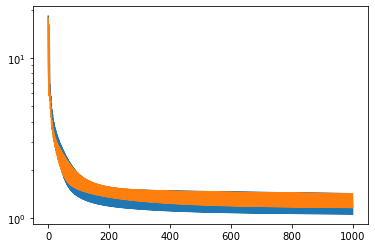

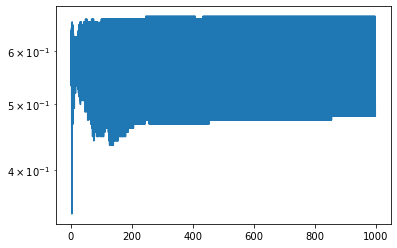

              precision    recall  f1-score   support

           0       0.68      0.98      0.80       102
           1       0.67      0.08      0.14        52

    accuracy                           0.68       154
   macro avg       0.67      0.53      0.47       154
weighted avg       0.67      0.68      0.58       154

f1_score:  0.46896551724137936
loss:  1.4137203693389893


In [5]:
model = nn.Sequential() 

model.add_module('l1',nn.Linear(8, 2))

model.add_module('ls', nn.LogSoftmax(dim=1))

TrainTestModels(model, torch.optim.RMSprop(model.parameters(), lr=0.008))


#### Два линейных слоя

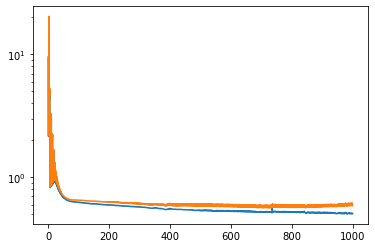

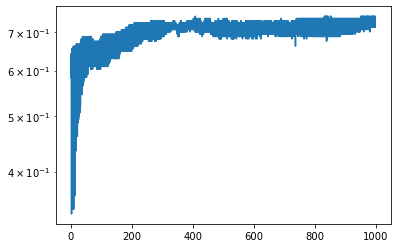

              precision    recall  f1-score   support

           0       0.74      0.96      0.83       102
           1       0.81      0.33      0.47        52

    accuracy                           0.75       154
   macro avg       0.77      0.64      0.65       154
weighted avg       0.76      0.75      0.71       154

f1_score:  0.6498979889245119
loss:  0.6192023754119873


In [6]:
model = nn.Sequential() 

model.add_module('l1', nn.Linear(8, 7)) 
model.add_module('a1', nn.ReLU()) 
model.add_module('l2', nn.Linear(7, 2)) 

model.add_module('ls', nn.LogSoftmax(dim=1))

TrainTestModels(model, torch.optim.RMSprop(model.parameters(), lr=0.008))

#### Три линейных слоя

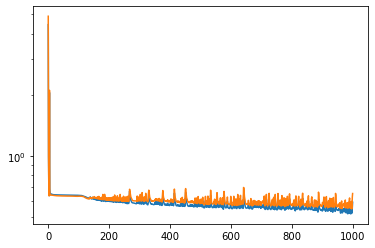

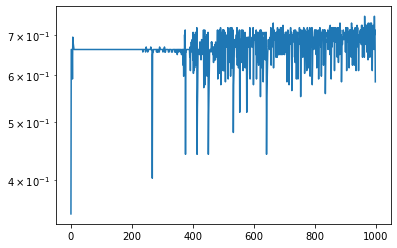

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       102
           1       0.54      0.62      0.58        52

    accuracy                           0.69       154
   macro avg       0.67      0.68      0.67       154
weighted avg       0.71      0.69      0.70       154

f1_score:  0.6689989481867655
loss:  0.5918924808502197


In [7]:
model = nn.Sequential() 

model.add_module('l1', nn.Linear(8, 7)) 
model.add_module('a1', nn.ReLU()) 
model.add_module('l2', nn.Linear(7, 6))
model.add_module('a2', nn.ReLU())
model.add_module('l3', nn.Linear(6, 2))

model.add_module('ls', nn.LogSoftmax(dim=1))

TrainTestModels(model, torch.optim.RMSprop(model.parameters(), lr=0.008))

#### Четыре линейных слоя

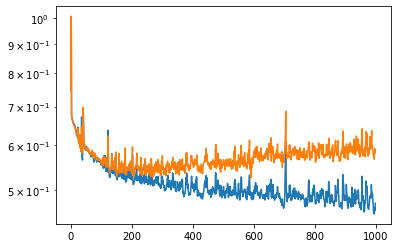

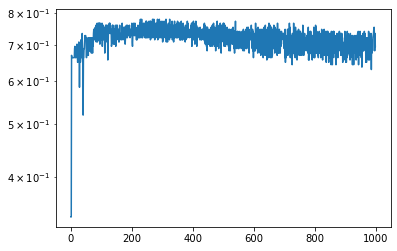

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       102
           1       0.65      0.46      0.54        52

    accuracy                           0.73       154
   macro avg       0.70      0.67      0.68       154
weighted avg       0.72      0.73      0.72       154

f1_score:  0.6760556154122415
loss:  0.5867060422897339


In [8]:
model = nn.Sequential() 

model.add_module('l1', nn.Linear(8, 7)) 
model.add_module('a1', nn.ReLU()) 
model.add_module('l2', nn.Linear(7, 6))
model.add_module('a2', nn.ReLU())
model.add_module('l3', nn.Linear(6, 5))
model.add_module('a3', nn.ReLU())
model.add_module('l4', nn.Linear(5, 2))

model.add_module('ls', nn.LogSoftmax(dim=1))
    

TrainTestModels(model, torch.optim.RMSprop(model.parameters(), lr=0.008))

### 2.4 Попробуйте различные функции активации
Обучите 4 модели, используя 4 различных функции активации на промежуточных слоях: sigmoid, tanh, ReLU, ELU. На выходном слое в качестве функции активации используйте сигмоиду.

Постройте: 1) график loss для train и test в зависимости от используемой функции активации; 2) график accuracy для train и test в зависимости от используемой функции активации;

In [9]:
def FourLayerModel (ActivationFunc, OptimizationAlgorithm):
    model = nn.Sequential() 
    
    model.add_module('l1', nn.Linear(8, 7)) 
    model.add_module('a1', ActivationFunc())
    model.add_module('l2', nn.Linear(7, 6))
    model.add_module('a2', ActivationFunc())
    model.add_module('l3', nn.Linear(6, 5))
    model.add_module('a3', ActivationFunc())
    model.add_module('l4', nn.Linear(5, 2))

    model.add_module('ls', nn.LogSoftmax(dim=1))
    

    TrainTestModels(model, OptimizationAlgorithm(model.parameters(), lr=0.008))

#### Функция активации ELU

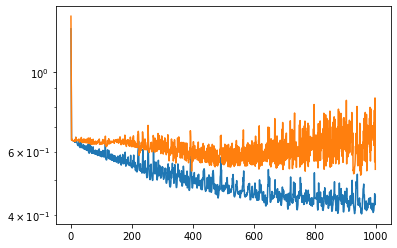

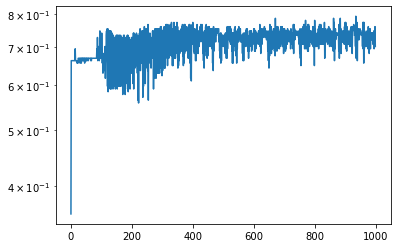

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       102
           1       0.66      0.48      0.56        52

    accuracy                           0.74       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.74      0.73       154

f1_score:  0.6860346585117227
loss:  0.7160053253173828


In [10]:
FourLayerModel(nn.ELU, torch.optim.RMSprop)

#### Функция активации ReLU

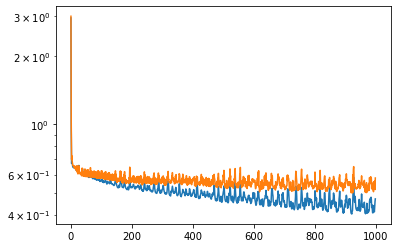

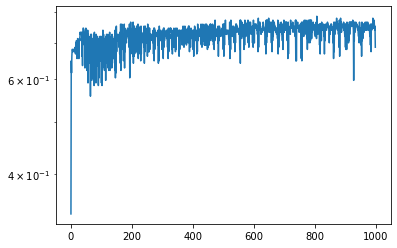

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       102
           1       0.75      0.40      0.53        52

    accuracy                           0.75       154
   macro avg       0.75      0.67      0.68       154
weighted avg       0.75      0.75      0.73       154

f1_score:  0.6791666666666667
loss:  0.5859436392784119


In [11]:
FourLayerModel(nn.ReLU, torch.optim.RMSprop)

#### Функция активации Sigmoid

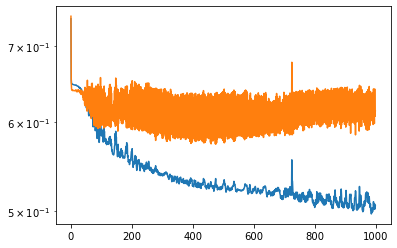

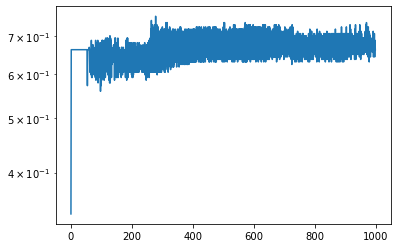

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       102
           1       0.59      0.52      0.55        52

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154

f1_score:  0.6707482993197279
loss:  0.5901743769645691


In [12]:
FourLayerModel(nn.Sigmoid, torch.optim.RMSprop)

#### Функция активации Tanh

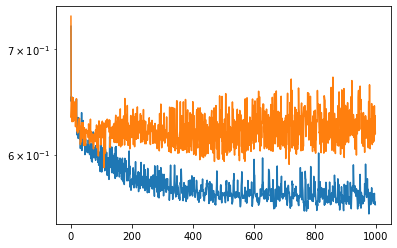

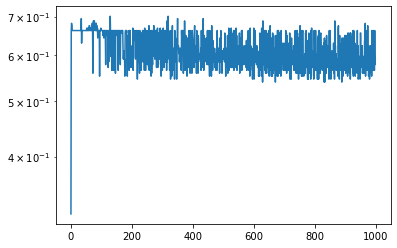

              precision    recall  f1-score   support

           0       0.79      0.47      0.59       102
           1       0.42      0.75      0.54        52

    accuracy                           0.56       154
   macro avg       0.60      0.61      0.56       154
weighted avg       0.66      0.56      0.57       154

f1_score:  0.5634440448487412
loss:  0.6420198082923889


In [13]:
FourLayerModel(nn.Tanh, torch.optim.RMSprop)

#### 2.5 Попробуйте различные алгоритмы оптимизации
Обучите 4 модели, используя 4 различных алгоритма оптимизации: SGD, SGD with momentum, RMSprop, Adam

Постройте: 1) график loss для train и test в зависимости от используемого алгоритма оптимизации; 2) график accuracy для train и test в зависимости от используемого алгоритма оптимизации.

 #### Алгоритм оптимизации RMSprop

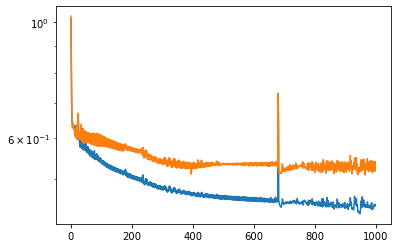

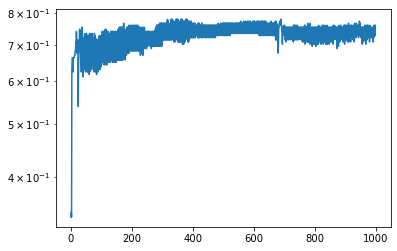

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       102
           1       0.60      0.71      0.65        52

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.76      0.74      0.74       154

f1_score:  0.7214686200036173
loss:  0.5273654460906982


In [14]:
FourLayerModel(nn.ELU, torch.optim.RMSprop)

 #### Алгоритм оптимизации SGD

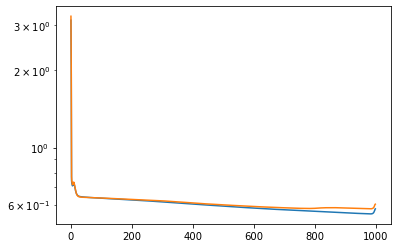

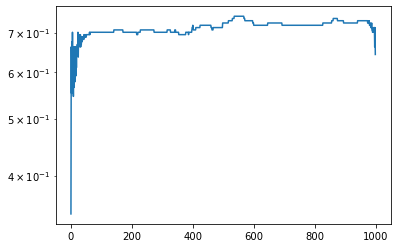

              precision    recall  f1-score   support

           0       0.70      0.98      0.82       102
           1       0.82      0.17      0.29        52

    accuracy                           0.71       154
   macro avg       0.76      0.58      0.55       154
weighted avg       0.74      0.71      0.64       154

f1_score:  0.5510204081632653
loss:  0.6095647811889648


In [15]:
FourLayerModel(nn.ELU, torch.optim.SGD)

 #### Алгоритм оптимизации Adam

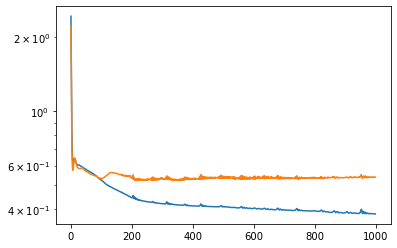

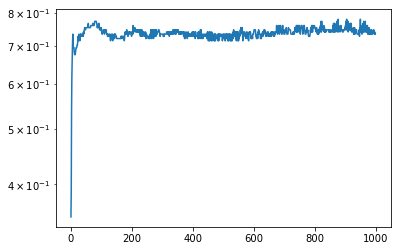

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       102
           1       0.61      0.65      0.63        52

    accuracy                           0.74       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.75      0.74      0.74       154

f1_score:  0.7148148148148148
loss:  0.539335310459137


In [16]:
FourLayerModel(nn.ELU, torch.optim.Adam)

 #### Алгоритм оптимизациии SGD momentum=0.4

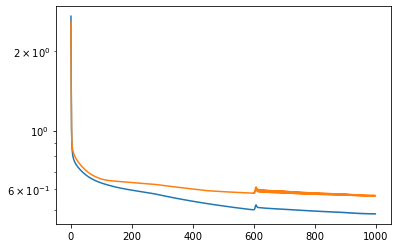

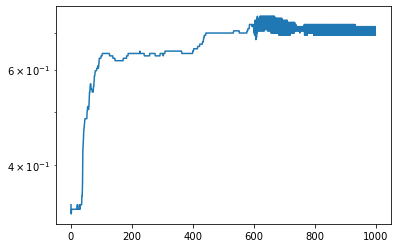

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       102
           1       0.63      0.42      0.51        52

    accuracy                           0.72       154
   macro avg       0.69      0.65      0.66       154
weighted avg       0.71      0.72      0.70       154

f1_score:  0.6555884953450877
loss:  0.5702584981918335


In [48]:
model = nn.Sequential() 

model.add_module('l1', nn.Linear(8, 7)) 
model.add_module('a1', nn.ELU())
model.add_module('l2', nn.Linear(7, 6))
model.add_module('a2', nn.ELU())
model.add_module('l3', nn.Linear(6, 5))
model.add_module('a3', nn.ELU())
model.add_module('l4', nn.Linear(5, 2))

model.add_module('ls', nn.LogSoftmax(dim=1))

TrainTestModels(model, torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.4))


#### 2.6 Попробуйте добавить dropout и batch norm
Обучите 5 моделей, используя 5 различных конфигураций: только BatchNorm, только dropout 0.2, только dropout 0.5, BatchNorm + dropout 0.2, BatchNorm + dropout 0.5.

Постройте: 1) график loss для train и test в зависимости от используемой конфигурации; 2) график accuracy для train и test в зависимости от используемой конфигурации.

In [49]:
def Layer (configurationB, configurationD, p = 0) :
    model = nn.Sequential() 

    model.add_module('l1', nn.Linear(8,7))    
    if configurationB:
        model.add_module('bn1', nn.BatchNorm1d(7))
    if configurationD:
        model.add_module('do1', nn.Dropout(p=p))
    model.add_module('a1', nn.ELU())

    model.add_module('l2', nn.Linear(7,6))
    if configurationB:
        model.add_module('bn2', nn.BatchNorm1d(6))
    if configurationD:
        model.add_module('do2', nn.Dropout(p=p))
    model.add_module('a2', nn.ELU())

    model.add_module('l3', nn.Linear(6,5))
    if configurationB:
        model.add_module('bn3', nn.BatchNorm1d(5))
    if configurationD:
        model.add_module('do3', nn.Dropout(p=p))
    model.add_module('a3', nn.ELU())

    model.add_module('l4', nn.Linear(5,2))
    
    model.add_module('ls', nn.LogSoftmax(dim=1))

    TrainTestModels(model, torch.optim.RMSprop(model.parameters(), lr=0.008))

#### Конфигурация BatchNorm

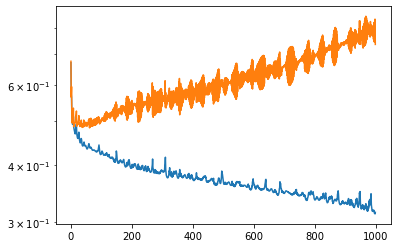

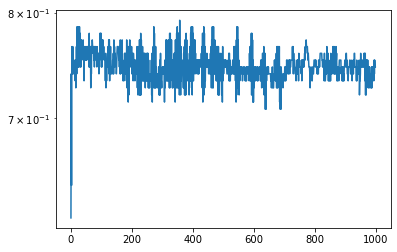

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       102
           1       0.62      0.63      0.63        52

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

f1_score:  0.7182266009852216
loss:  0.851165771484375


In [50]:
Layer(True, False)

#### Конфигурация dropout 0.2

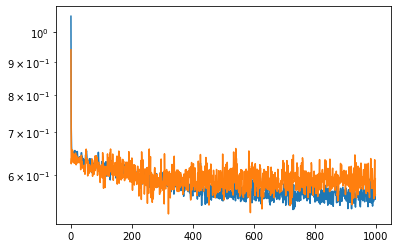

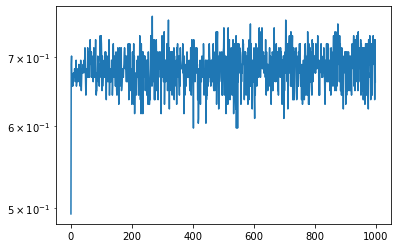

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       102
           1       0.58      0.42      0.49        52

    accuracy                           0.70       154
   macro avg       0.66      0.63      0.64       154
weighted avg       0.69      0.70      0.69       154

f1_score:  0.6389398572884811
loss:  0.5745120644569397


In [51]:
Layer(False, True, 0.2)

#### Конфигурация dropout 0.5

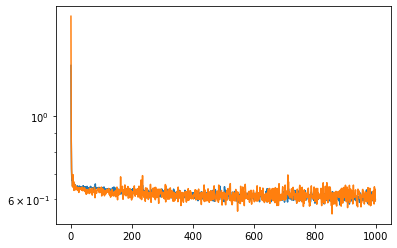

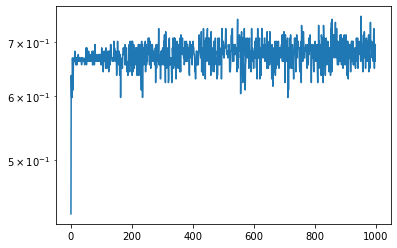

              precision    recall  f1-score   support

           0       0.72      0.92      0.81       102
           1       0.65      0.29      0.40        52

    accuracy                           0.71       154
   macro avg       0.68      0.61      0.60       154
weighted avg       0.70      0.71      0.67       154

f1_score:  0.6034334763948498
loss:  0.5996596813201904


In [52]:
Layer(False, True, 0.5)

#### Конфигурация BatchNorm и dropout 0.2

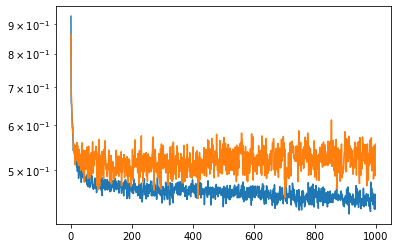

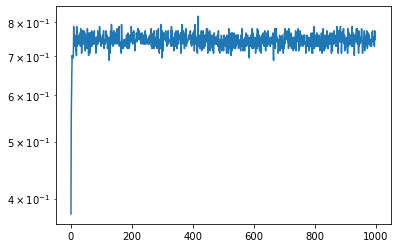

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       102
           1       0.60      0.67      0.64        52

    accuracy                           0.74       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.75      0.74      0.74       154

f1_score:  0.7171717171717171
loss:  0.5417305827140808


In [53]:
Layer(True, True, 0.2)

#### Конфигурация BatchNorm и dropout 0.5

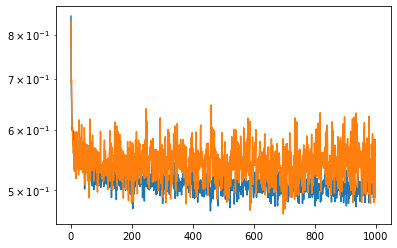

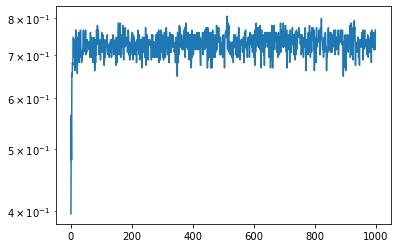

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       102
           1       0.68      0.62      0.65        52

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154

f1_score:  0.7395002658160552
loss:  0.5481812357902527


In [60]:
Layer(True, True, 0.5)

### 2.7 Постройте финальную модель
Используя информацию, полученную на предыдущих этапах, предложите оптимальную конфигурацию нейронной сети для вашей задачи. Обучите модель.

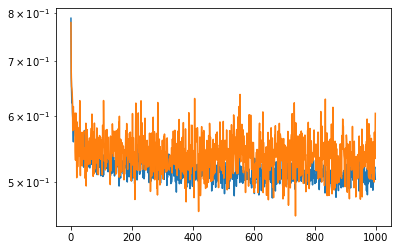

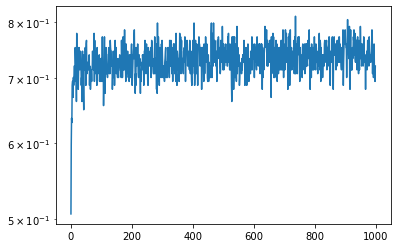

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       102
           1       0.68      0.62      0.65        52

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154

f1_score:  0.7395002658160552
loss:  0.5452145934104919


In [63]:
Layer(True, True, 0.5)

### 2.8 Выводы
Your beautiful thoughts: 4-х слойная модель, обученная алгоритмом оптимизации RMSprop, функцией активации ELU и конфигурацией BatchNorm + dropout 0.5, показала самую высокую точность при обучении: f1_score ~ 0.74